In [1]:
import pandas as pd
import numpy as np
import glob
from resampling import time_resampling


import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
###### Aplicação da Função para resampling da base de dados, deixando em formato horário. #################
###### Arquivo da Função: resampling.py
###########################################################################################################
df0= time_resampling('C:/Users/gusta/Google Drive/dados_desafio/2010.csv','1D')
df1= time_resampling('C:/Users/gusta/Google Drive/dados_desafio/2011.csv','1D')
df2= time_resampling('C:/Users/gusta/Google Drive/dados_desafio/2012.csv','1D')
df3= time_resampling('C:/Users/gusta/Google Drive/dados_desafio/2013.csv','1D')
df4= time_resampling('C:/Users/gusta/Google Drive/dados_desafio/2014.csv','1D')
df5= time_resampling('C:/Users/gusta/Google Drive/dados_desafio/2015.csv','1D')
df6= time_resampling('C:/Users/gusta/Google Drive/dados_desafio/2016.csv','1D')
df7= time_resampling('C:/Users/gusta/Google Drive/dados_desafio/2017.csv','1D')
#########################################################################,'1D'###################################

In [3]:
##### Concatenando as bases anuais para formação da série temporal. 
df= pd.concat([df0,df1,df2,df3,df4,df5,df6,df7],axis=0)
df

,entries,exits
time,,
2010-04-17,5.812548e+10,4.953496e+10
2010-04-18,7.077174e+10,6.115159e+10
2010-04-19,7.382511e+10,6.349756e+10
2010-04-20,7.234986e+10,6.115444e+10
2010-04-21,7.054381e+10,6.185858e+10
...,...,...
2017-09-19,1.117203e+12,8.926680e+11
2017-09-20,1.134720e+12,9.066210e+11
2017-09-21,1.144419e+12,9.201752e+11


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2717 entries, 2010-04-17 to 2017-09-23
Freq: D
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   entries  2717 non-null   float64
 1   exits    2717 non-null   float64
dtypes: float64(2)
memory usage: 63.7 KB


In [5]:
df.describe()

,entries,exits
count,2.717000e+03,2.717000e+03
mean,4.320449e+11,3.454457e+11
std,4.013090e+11,3.217753e+11
min,0.000000e+00,0.000000e+00
25%,7.991038e+10,6.898809e+10
50%,1.785344e+11,1.350708e+11
75%,8.978455e+11,7.349952e+11
max,1.260766e+12,1.073072e+12


In [6]:
# processando dados faltantes na série histórica
df['entries']=df['entries'].mask(df['entries'] == 0).ffill(downcast='infer')

In [7]:
df.shape

(2717, 2)

In [8]:
df[['entries']].describe()

,entries
count,2.717000e+03
mean,4.320978e+11
std,4.012528e+11
min,1.189887e+10
25%,7.991038e+10
50%,1.785344e+11
75%,8.978455e+11
max,1.260766e+12


<AxesSubplot:xlabel='time'>

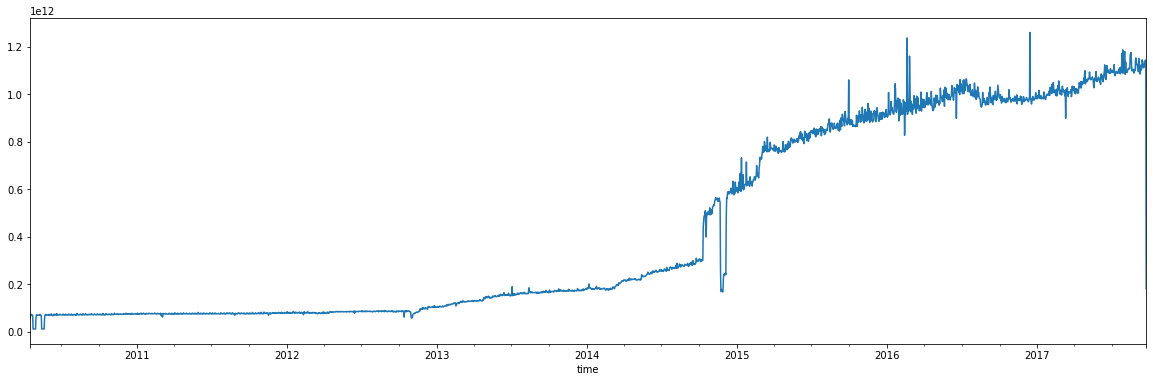

In [9]:
df['entries'].plot(figsize=(20,6))

In [10]:
series=df[['entries']]
series= series.head(series.shape[0]-1) ## excluindo o dia 2017-09-23  que possui dados inconpletos 

# Gerando os dados sequenciais para a rede recorrente

In [11]:
janela= 14 # tamanho da janela deslizante utilizada -> N° de observações passadas
horizon=1  # horizonte de previsão

for i in range(0,janela):
    name= 'shihft_' + str(i+1)
    series[name]= series['entries'].shift(i+1)
    
series= series[series.columns[::-1]]   
series['Label']= series['entries'].shift(-horizon)
series=series.dropna()

# Divisão treino - teste cronológica

In [12]:
series['Label']=series['Label']/10000000000 #trabalhamos com o Label em menor escala para facilitar o calculo do erro na rede
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(series.drop(['Label'],axis=1), series[['Label']],
                                                    test_size=0.2, shuffle=False)

In [13]:
X_train.head(1)

,shihft_14,shihft_13,shihft_12,shihft_11,shihft_10,shihft_9,shihft_8,shihft_7,shihft_6,shihft_5,shihft_4,shihft_3,shihft_2,shihft_1,entries
time,,,,,,,,,,,,,,,
2010-05-01,5.812548e+10,7.077174e+10,7.382511e+10,7.234986e+10,7.054381e+10,6.904329e+10,7.020471e+10,1.189887e+10,1.189887e+10,1.189887e+10,1.189887e+10,1.189887e+10,1.189887e+10,1.189887e+10,57030898125


In [14]:
y_test.tail(1)

,Label
time,
2017-09-21,112.07152


In [15]:
# processamento e reshape dos dados para a arquitetura da LSTM
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X= (X_train.values)
Y= y_train.values
    
scaler.fit(X)
X= scaler.transform(X)

X2= (X_test.values)
X2= scaler.transform(X2)
    
X= np.reshape(X,newshape= (X.shape[0],X.shape[1],1))
X2= np.reshape(X2,newshape= (X2.shape[0],X2.shape[1],1))



Y2= y_test.values
print(X.shape)
print(X2.shape)

(2160, 15, 1)
(541, 15, 1)


# Construção da rede neural

In [71]:
import tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

#*** A função de ativação linear apresentou melhores resultados quando empregada em todas as camadas da rede. ]
# **** Diversos hiperparametros foram testados

model = Sequential()

##CAMADA DE ENTRADA 
model.add(LSTM(units = 100 , activation='linear', return_sequences =True,input_shape = (X.shape[1], X.shape[2])))
model.add(Dropout(0.2))

################################################################################
model.add(LSTM(units = 50, activation='linear', return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units= 50, activation='linear'))
model.add(Dropout(0.2))
###############################################################################


# CAMADA DE SAÍDA 
model.add(Dense(units = 1,activation= 'linear'))

# Compilando a LSTM
model.compile(optimizer = 'Adagrad', loss = 'mean_squared_logarithmic_error',metrics=['mape'])
#fitting
history=model.fit(X,Y, epochs = 300, batch_size = 100,validation_data=(X2, Y2))

Epoch 1/300
22/22 [==============================] - 5s 95ms/step - loss: 9.1067 - mape: 99.4444 - val_loss: 18.6780 - val_mape: 99.6378
Epoch 2/300
22/22 [==============================] - 1s 47ms/step - loss: 7.9470 - mape: 97.7851 - val_loss: 16.3991 - val_mape: 99.2182
Epoch 3/300
22/22 [==============================] - 1s 48ms/step - loss: 7.0907 - mape: 96.0547 - val_loss: 14.0674 - val_mape: 98.6048
Epoch 4/300
22/22 [==============================] - 1s 48ms/step - loss: 5.8948 - mape: 93.6734 - val_loss: 11.6046 - val_mape: 97.6297
Epoch 5/300
22/22 [==============================] - 1s 48ms/step - loss: 4.7264 - mape: 89.9526 - val_loss: 9.0946 - val_mape: 96.0281
Epoch 6/300
22/22 [==============================] - 1s 48ms/step - loss: 3.5816 - mape: 84.4541 - val_loss: 6.6508 - val_mape: 93.3163
Epoch 7/300
22/22 [==============================] - 1s 48ms/step - loss: 2.3552 - mape: 75.6622 - val_loss: 4.3137 - val_mape: 88.3208
Epoch 8/300
22/22 [=========================

22/22 [==============================] - 1s 49ms/step - loss: 0.0855 - mape: 25.7733 - val_loss: 0.0703 - val_mape: 30.3318
Epoch 61/300
22/22 [==============================] - 1s 56ms/step - loss: 0.0927 - mape: 27.7199 - val_loss: 0.0726 - val_mape: 30.8974
Epoch 62/300
22/22 [==============================] - 1s 60ms/step - loss: 0.0902 - mape: 27.2389 - val_loss: 0.0735 - val_mape: 31.1226
Epoch 63/300
22/22 [==============================] - 1s 53ms/step - loss: 0.0923 - mape: 27.5309 - val_loss: 0.0724 - val_mape: 30.8696
Epoch 64/300
22/22 [==============================] - 1s 51ms/step - loss: 0.0924 - mape: 27.5488 - val_loss: 0.0710 - val_mape: 30.5214
Epoch 65/300
22/22 [==============================] - 1s 51ms/step - loss: 0.0875 - mape: 27.9998 - val_loss: 0.0706 - val_mape: 30.4136
Epoch 66/300
22/22 [==============================] - 1s 50ms/step - loss: 0.0887 - mape: 26.6870 - val_loss: 0.0718 - val_mape: 30.7217
Epoch 67/300
22/22 [==============================] - 

Epoch 120/300
22/22 [==============================] - 1s 49ms/step - loss: 0.0757 - mape: 25.5717 - val_loss: 0.0274 - val_mape: 17.9996
Epoch 121/300
22/22 [==============================] - 1s 49ms/step - loss: 0.0737 - mape: 24.5732 - val_loss: 0.0252 - val_mape: 17.1693
Epoch 122/300
22/22 [==============================] - 1s 51ms/step - loss: 0.0820 - mape: 25.5949 - val_loss: 0.0249 - val_mape: 17.0778
Epoch 123/300
22/22 [==============================] - 1s 49ms/step - loss: 0.0704 - mape: 24.0288 - val_loss: 0.0242 - val_mape: 16.8152
Epoch 124/300
22/22 [==============================] - 1s 51ms/step - loss: 0.0731 - mape: 23.9920 - val_loss: 0.0226 - val_mape: 16.1858
Epoch 125/300
22/22 [==============================] - 1s 50ms/step - loss: 0.0713 - mape: 23.4575 - val_loss: 0.0234 - val_mape: 16.5172
Epoch 126/300
22/22 [==============================] - 1s 51ms/step - loss: 0.0803 - mape: 25.5421 - val_loss: 0.0241 - val_mape: 16.7708
Epoch 127/300
22/22 [=============

22/22 [==============================] - 1s 54ms/step - loss: 0.0620 - mape: 21.8949 - val_loss: 0.0084 - val_mape: 9.4256
Epoch 180/300
22/22 [==============================] - 1s 54ms/step - loss: 0.0648 - mape: 21.6690 - val_loss: 0.0078 - val_mape: 9.0808
Epoch 181/300
22/22 [==============================] - 1s 55ms/step - loss: 0.0731 - mape: 24.0753 - val_loss: 0.0085 - val_mape: 9.4781
Epoch 182/300
22/22 [==============================] - 1s 52ms/step - loss: 0.0614 - mape: 21.0774 - val_loss: 0.0079 - val_mape: 9.1469
Epoch 183/300
22/22 [==============================] - 1s 53ms/step - loss: 0.0668 - mape: 22.2666 - val_loss: 0.0078 - val_mape: 9.0485
Epoch 184/300
22/22 [==============================] - 1s 51ms/step - loss: 0.0626 - mape: 22.7251 - val_loss: 0.0076 - val_mape: 8.9358
Epoch 185/300
22/22 [==============================] - 1s 52ms/step - loss: 0.0648 - mape: 22.1749 - val_loss: 0.0070 - val_mape: 8.5371
Epoch 186/300
22/22 [==============================] - 

Epoch 239/300
22/22 [==============================] - 1s 50ms/step - loss: 0.0540 - mape: 19.1702 - val_loss: 0.0021 - val_mape: 4.2780
Epoch 240/300
22/22 [==============================] - 1s 50ms/step - loss: 0.0531 - mape: 19.5275 - val_loss: 0.0023 - val_mape: 4.5301
Epoch 241/300
22/22 [==============================] - 1s 50ms/step - loss: 0.0556 - mape: 20.1924 - val_loss: 0.0024 - val_mape: 4.5717
Epoch 242/300
22/22 [==============================] - 1s 50ms/step - loss: 0.0608 - mape: 21.7371 - val_loss: 0.0022 - val_mape: 4.3727
Epoch 243/300
22/22 [==============================] - 1s 49ms/step - loss: 0.0563 - mape: 19.7610 - val_loss: 0.0022 - val_mape: 4.3880
Epoch 244/300
22/22 [==============================] - 1s 50ms/step - loss: 0.0561 - mape: 20.3325 - val_loss: 0.0022 - val_mape: 4.3034
Epoch 245/300
22/22 [==============================] - 1s 49ms/step - loss: 0.0628 - mape: 21.7865 - val_loss: 0.0024 - val_mape: 4.6345
Epoch 246/300
22/22 [====================

Epoch 299/300
22/22 [==============================] - 1s 52ms/step - loss: 0.0538 - mape: 19.0089 - val_loss: 0.0015 - val_mape: 3.4151
Epoch 300/300
22/22 [==============================] - 1s 51ms/step - loss: 0.0516 - mape: 19.1151 - val_loss: 0.0012 - val_mape: 2.9975


# Curva de Aprendizado 

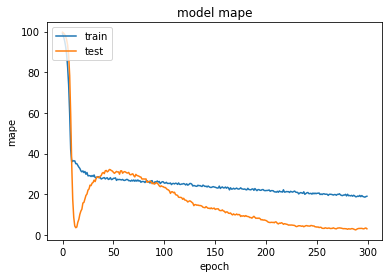

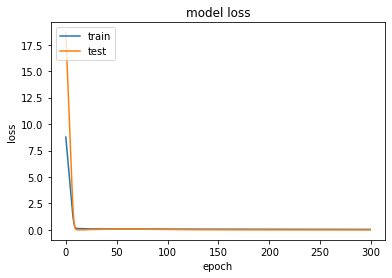

In [72]:
import matplotlib.pyplot as plt\
# summarize history for mape
plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.title('model mape')
plt.ylabel('mape')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

As curvas de aprendizado, tanto para o loss e para o mape, apresentam um bom desempenho, indicando que possivelmente não houve overfitting. A aplicação de uma técnica de otimização dos hiperparametros ou automl é indicada, no entanto requer um alto poder de processamento. 

In [73]:
predictions=model.predict(X2)
predictions_train=model.predict(X)

In [74]:
y_test['Pred']=predictions
y_train['Pred']=predictions_train

# Visualização das predições

<AxesSubplot:xlabel='time'>

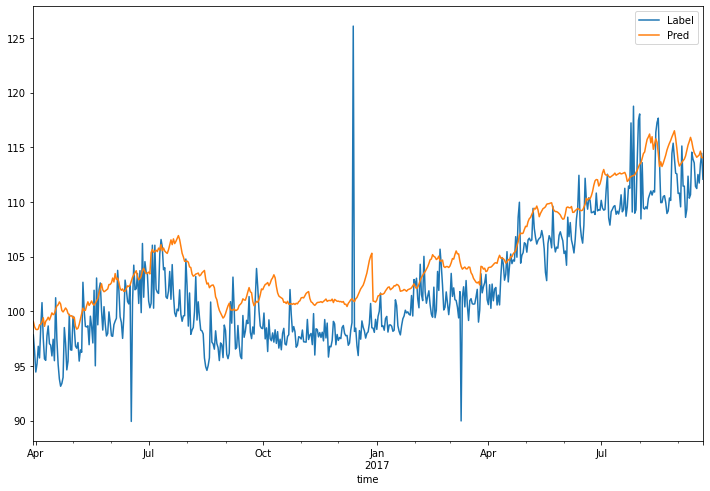

In [75]:
y_test.plot(figsize=(12,8))

In [83]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('MAPE: ',mean_absolute_percentage_error(y_test['Label'],y_test['Pred'])*100)
print('R2: ',r2_score(y_test['Label'],y_test['Pred']))
print('MSE: ',mean_squared_error(y_test['Label'],y_test['Pred']))

MAPE:  2.9974735408645623
R2:  0.5479653033451222
MSE:  13.195681059258266


In [79]:
Table=pd.concat([X_test/10000000000,y_test],axis=1)

In [80]:
#Acerto de direção:
Table['Mov_true']=Table['Label']-Table['entries']
Table['Mov_Pred']=Table['Pred']- Table['entries']

Table['Mov_true']  = np.where(Table['Mov_true']>0, 'Alta', 'Queda')
Table['Mov_Pred']  = np.where(Table['Mov_Pred']>0, 'Alta', 'Queda')

from sklearn.metrics import classification_report
print(classification_report(Table['Mov_true'], Table['Mov_Pred']))

              precision    recall  f1-score   support

        Alta       0.52      0.97      0.68       261
       Queda       0.86      0.18      0.30       280

    accuracy                           0.56       541
   macro avg       0.69      0.58      0.49       541
weighted avg       0.70      0.56      0.48       541



Calculo do acerto de direção nas previsões -> Não usual em regressão. No entanto, para séries financeiras é importante saber a capacidade do modelo em acertar a direção do mercado. No caso da série histórica do metrô também pode ser útil para indicar aumento ou diminuição no tráfego de pessoas. 